**Общая информация**

Совместно с маркетинговым отделом были подготовлены ряд гипотез для увеличения прибыли.В ходе проекта проекта приоритезировать предложенные гипотезы, запустить А/В тест и проанализировать полученные результаты. 

**Задача проекта:** приоритезация гипотез, анализ результатов, полученных в ходе А/В теста


**Цель проекта:** принять решение по результатам А/В теста о приостановке или продолжении тестирования, принять решение об успешности тестирования 

### Импорт данных


In [1]:
#Загружаем библиотеки
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import warnings

In [2]:
#Загружаем датасет с гипотезами
hypothesis=pd.read_csv('/datasets/hypothesis.csv')
#Загружаем датасет с данными о заказах
orders=pd.read_csv('/datasets/orders.csv')
#Загружаем датасет с данными о посещениях сайта
visitors=pd.read_csv('/datasets/visitors.csv')

### Предобработка данных

In [3]:
#Посмотрим общую информацию по таблице
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


*В таблице нет пропусков, формат данных корректный*

In [4]:
# Приведем название столбцов к нижнему регистру
hypothesis.columns=hypothesis.columns.str.lower() 

In [5]:
#Посмотрим общую информацию по таблице заказов
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


*В таблице отсутствуют пропущенные значения, необходимо заменить формат даты*

In [6]:
# Переименуем столбцы в основной таблице
orders=orders.rename(columns={'transactionId':'transaction_id', 'visitorId':'visitor_id'})

In [7]:
# Проверим наличие явных дубликатов
print('Количество явных дубликатов в таблице orders:', orders.duplicated().sum())

Количество явных дубликатов в таблице orders: 0


*В таблице отсутствуют явные дубликаты*

In [8]:
# Проверим наличие неявных дубликатов
print('Количество неявных дубликатов в таблице orders:', orders.duplicated(subset=['transaction_id', 'visitor_id']).sum())

Количество неявных дубликатов в таблице orders: 0


*В таблице отсутствуют неявные дубликаты по показателям номер заказа/id пользователя*

In [9]:
# Проверим отсутствие дубликатов заказов в разных группах
print('Количество заказов в группе А:', orders.query('group in "A"')['transaction_id'].nunique())
print('Количество заказов в группе В:', orders.query('group in "B"')['transaction_id'].nunique())
print('Количество уникальных заказов:', orders['transaction_id'].nunique())

Количество заказов в группе А: 557
Количество заказов в группе В: 640
Количество уникальных заказов: 1197


*Количество уникальных заказов по группам соответствует общему количеству заказов, дубликатов в группах нет*

In [10]:
# Проверим отсутствие дубликатов пользователей в разных группах заказов
print('Количество уникальных пользователей в группе А:', orders.query('group in "A"')['visitor_id'].nunique())
print('Количество уникальных пользователей в группе В:', orders.query('group in "B"')['visitor_id'].nunique())
print('Количество уникальных пользователей:', orders['visitor_id'].nunique())
print('Доля пользователей в группе А:', "{0:.3f}".format(orders.query('group in "A"')['visitor_id'].nunique()\
      /(orders.query('group in "A"')['visitor_id'].nunique()+orders.query('group in "B"')['visitor_id'].nunique())))
print('Доля пользователей в группе В:', "{0:.3f}".format(orders.query('group in "B"')['visitor_id'].nunique()\
     /(orders.query('group in "A"')['visitor_id'].nunique()+orders.query('group in "B"')['visitor_id'].nunique())))

Количество уникальных пользователей в группе А: 503
Количество уникальных пользователей в группе В: 586
Количество уникальных пользователей: 1031
Доля пользователей в группе А: 0.462
Доля пользователей в группе В: 0.538


In [11]:
#Приведем дату в таблице заказов к формату дата
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
#Посмотрим общую информацию по таблице посещений
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


*В таблице отсутствуют пропущенные значения, необходимо заменить форматы даты*

In [13]:
# Проверим наличие явных дубликатов дубликатов в таблице посещений
print('Количество явных дубликатов в таблице visitors:', visitors.duplicated().sum())

Количество явных дубликатов в таблице visitors: 0


In [14]:
# Проверим наличие неявных дубликатов дубликатов в таблице посещений
print('Количество неявных дубликатов в таблице visitors:',visitors.duplicated(subset=['date', 'group']).sum())

Количество неявных дубликатов в таблице visitors: 0


In [15]:
#Приведем дату в таблице посещений к формату дата
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [16]:
print(f"Период проведения эксперимента таблица order: {orders['date'].min()}-{orders['date'].max()}")
print(f"Период проведения эксперимента таблица visitors: \
{visitors['date'].min()}-{visitors['date'].max()}")

Период проведения эксперимента таблица order: 2019-08-01 00:00:00-2019-08-31 00:00:00
Период проведения эксперимента таблица visitors: 2019-08-01 00:00:00-2019-08-31 00:00:00


*Период проведения эксперимента в обеих таблицах совпадает и составлет 1 месяц*

**Выводу по этапу предобработка данных:**

- проверено отсутствие пропусков и дубликатов

- заменен формат данных в столбцах с датами

- выявлено 5% пользователей, попавших в обе группы тестирования 

- проверены начало и конец тестирования в таблицах с заказами и посещениями


### Приоритезация гипотез

#### Фреймворк ICE

In [17]:
# Применим фреймворк ICE для приоритизации гипотез
pd.options.display.max_colwidth = 1
hypothesis['ICE']=(hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis', 'ICE', 'impact']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE,impact
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000,9
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333,10
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000,7
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000,3
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000,3
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000,5
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333,2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000,1


*При применении фреймворка ICE наиболее приоритетными являются гипотезы 8, 0, 7*

#### Фреймворк RICE

In [18]:
pd.options.display.max_colwidth = 1
hypothesis['RICE']=hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']/hypothesis['efforts']
display(hypothesis[['hypothesis', 'RICE', 'reach']].sort_values(by='RICE', ascending=False))

,hypothesis,RICE,reach
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0,8
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0,5
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2,1
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0,8
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0,2
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0,3
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0,3


При применении фреймворка RICE наиболее приоритетными являются гипотезы 7, 2, 0, 6. 

Различия в приоритетах гипотез связаны с добавлением параметра Reach. Добавление информации на основных страницах сайта охватывет большое количество пользователей, что обеспечивает высокое значение параметра Reach у гипотезы 7, тогда как акция в день рождения не обеспечивает большого охвата 

Исходя из полученных результатов, гипотезы 7, 2, 0 являются наиболее приоритетными  

**Вывод по этапу приоритезация гипотез:**

- В ходе приоритезации гипотез было установлено, что наиболее приоритетными являются гипотезы 7, 2, 0 
- Приоритет гипотез 8,0,7 изменяется при применении фреймворка RICE, так как гипотезы 7 и 2 обеспечивают больший охват пользователей

### Анализ A/B-теста

#### Анализ кумулятивной выручки по группам

In [19]:
#создадим массив уникальных пар значений дат и групп теста
datesGroups = orders[['date', 'group']].drop_duplicates() 

In [20]:
# Получим агрегированные кумулятивные по дням данные о заказах интернет-магазина
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            #строки таблицы orders, дата которых меньше или равна\
            #дате элемента из datesGroups, а группа теста равна группе из datesGroups
            orders['date'] <= x['date'], orders['group'] == x['group'] 
        )
    ].agg(
        {
            'date': 'max', #вычисляем максимальную дату
            'group': 'max', 
            'transaction_id': 'nunique', #число уникальных ID заказов
            'visitor_id': 'nunique', #число уникальных ID пользователей
            'revenue': 'sum', #сумма средних чеков
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])


In [21]:
# Проверим корректность формирования таблицы ordersAggregated
print('дата начала теста:', ordersAggregated['date'].min())
print('дата окончания теста:', ordersAggregated['date'].max())
print('количество записей:', ordersAggregated.shape[0])

дата начала теста: 2019-08-01 00:00:00
дата окончания теста: 2019-08-31 00:00:00
количество записей: 62


In [22]:
# Аналогично получим агрегированные кумулятивные по дням данные о посещениях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])


In [23]:
# Проверим корректность формирования таблицы visitorsAggregated
print('дата начала теста:', visitorsAggregated['date'].min())
print('дата окончания теста:', visitorsAggregated['date'].max())
print('количество записей:', visitorsAggregated.shape[0])

дата начала теста: 2019-08-01 00:00:00
дата окончания теста: 2019-08-31 00:00:00
количество записей: 62


In [24]:
# объединяем кумулятивные данные по заказам и посещениям в одной таблице 
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
# Переименуем столбцы
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]


In [25]:
# зададим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
#зададим датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

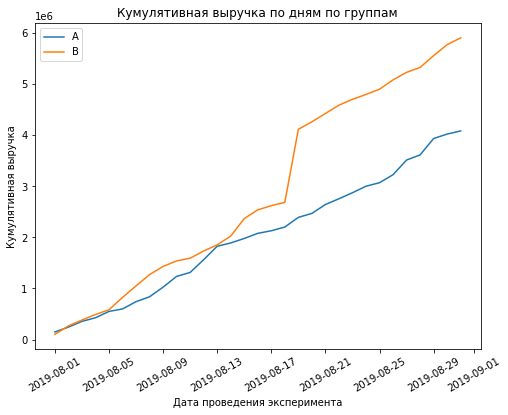

In [26]:
# Строим график выручки группы А
plt.figure(figsize=(8,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.xlabel('Дата проведения эксперимента')
plt.ylabel('Кумулятивная выручка')
plt.title('Кумулятивная выручка по дням по группам')
plt.xticks(rotation=30)
plt.show()

*На графике видим, что выручка в группе А растет равномерно, до середины эксперимента группа В немного превосходила группу А, однако для группы В наблюдается резкий скачок в период после 17 августа, возможно, это связано с аномально дорогими заказами в эти дни или увеличением числа заказов*

#### Анализ среднего чека по группам

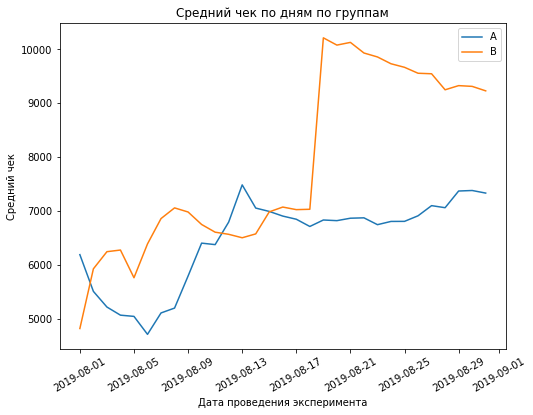

In [27]:
# Строим график среднего чека группы А
plt.figure(figsize=(8,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
# Строим график среднего чека группы В
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.xlabel('Дата проведения эксперимента')
plt.ylabel('Средний чек')
plt.title('Средний чек по дням по группам')
plt.xticks(rotation=30)
plt.show()

*Из графика видим, что для группы А значения среднего чека значительно колебались до 13 августа, затем вышли на стабильный уровень, в группе В есть резкие скачки до 7 августа и 18-19 августа,что соответствует скачкам в кумулятивной выручке. Возможно, в этот период попали дорогие заказы, средний чек стабилизируется только в последнюю декаду месяца и начинает снижение*

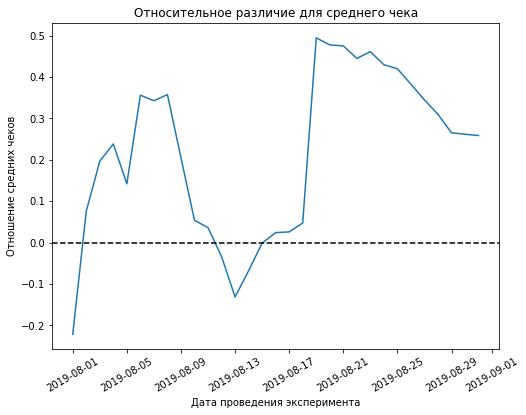

In [28]:
# собираем данные по группам в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(8,6))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xlabel('Дата проведения эксперимента')
plt.ylabel('Отношение средних чеков')
plt.title('Относительное различие для среднего чека')
plt.xticks(rotation=30)
plt.show()

*На графике аналогично видим резкие всплески и падения в отношении между группами. Исходя из такого поведения графиков средних чеков можно предположить, что в период до 7 августа и 18-19 августа в группу В попадали заказы, которые дают значительные выбросы по данным*

*Из построенных графиков выручки и среднего чека видим, что в отдельные дни были совершены аномально дорогие заказы, которые дают резкие всплески на графиках кумулятивной выручки и среднего чека. Средний чек для группы В стабилизируется только в последние 10 дней тестирования и начинает падение. Полученные данные не раскрывают реального поведения пользователей в группах* 

#### Анализ кумулятивной конверсии

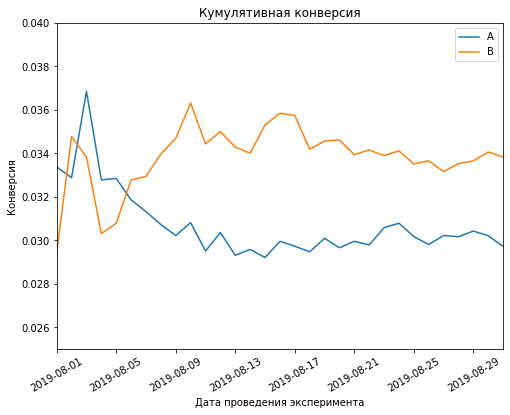

In [29]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
plt.figure(figsize=(8,6))
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
# задаем масштаб осей
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0.025, 0.04])
plt.xlabel('Дата проведения эксперимента')
plt.ylabel('Конверсия')
plt.title('Кумулятивная конверсия')
plt.xticks(rotation=30)
plt.show()

*В первые дни теста конверсия резко колеблется для обеих групп, возможно, это связано с попаданием аномально высоких заказов, при этом конверсия группы А выше. После 2-3 августа коверсия группы А начинает стремительное падение, тогда как в группе В наблюдается резкий рост, что скорее всего, также связано с попаданием аномальных заказов в этот период, после 9 августа данные в обеих группах стабилизируются, с небольшим выбросом 15 августа в группе В. В целом, конверсия группы В стабильно выше группы А*   

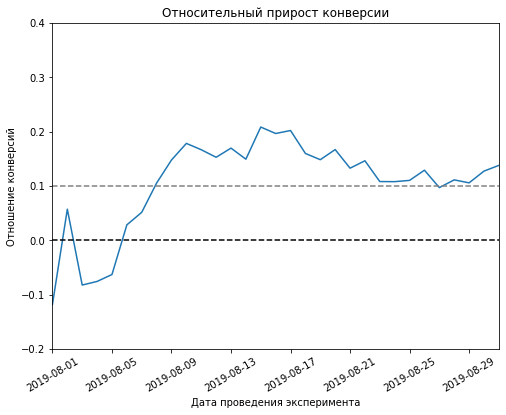

In [30]:
# Построим график относительного различия кумулятивных конверсий
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(8,6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31),-0.2, 0.4])
plt.xlabel('Дата проведения эксперимента')
plt.ylabel('Отношение конверсий')
plt.title('Относительный прирост конверсии')
plt.xticks(rotation=30)
plt.show()

*На графике видим, что до 5 августа конверсия в группе В была выше только 2 августа, после она начинает стремительно расти и остается стабильно выше более чем на 10%  до конца эксперимента, в последней декаде месяца наблюдается постепенный спад, но уровень сохраняется выше 10%* 

#### Анализ количества заказов по пользователям

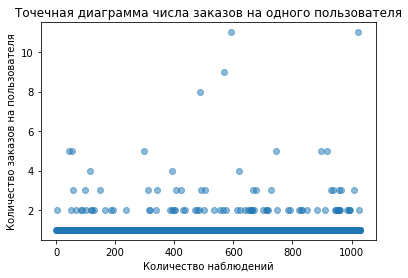

In [31]:
#Сгруппируем заказы по пользователям
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)
ordersByUsers.columns = ['visitor_id', 'orders']
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

# Построим диаграмму распределения заказов
plt.scatter(x_values, ordersByUsers['orders'], alpha=0.5)
plt.xlabel('Количество наблюдений')
plt.ylabel('Количество заказов на пользователя')
plt.title('Точечная диаграмма числа заказов на одного пользователя')
plt.show()

*Из графика видим, что основная часть пользователей совершила один заказ, небольшой процент сделали 2 заказа, большее число заказов совершила небольшая доля пользователей.*  

*Для более точной оценки распределения количества по пользователем посчитаем перцентили количества заказов на одного пользователя.*

In [32]:
#Посчитаем выборочные перцентили количества заказов на одного пользователя
print(f"90% пользователей сделали не более {np.percentile(ordersByUsers['orders'], [90])} заказа") 
print(f"95% пользователей сделали не более {np.percentile(ordersByUsers['orders'], [95])} заказов") 
print(f"99% пользователей сделали не более {np.percentile(ordersByUsers['orders'], [99])} заказов") 

90% пользователей сделали не более [1.] заказа
95% пользователей сделали не более [2.] заказов
99% пользователей сделали не более [4.] заказов


*95% пользователей совершают до 2 заказов. Большее число заказов примем за выбросы и исключим*

#### Анализ стоимости заказов по пользователям

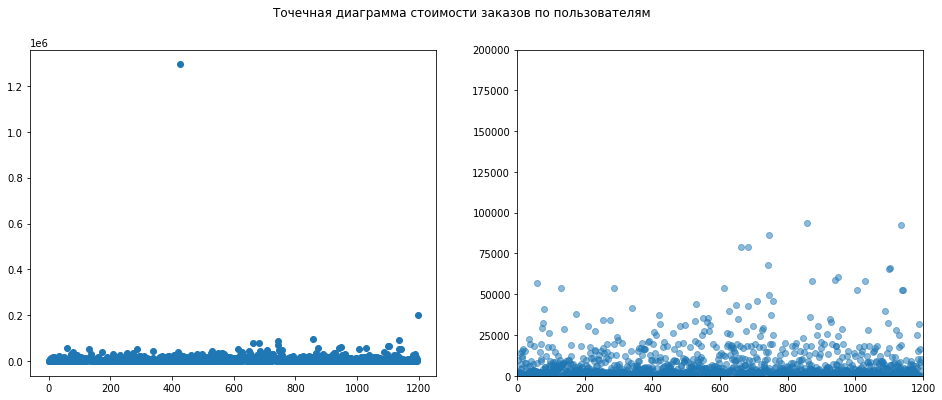

In [33]:
# построим график распрделения средней стоимости заказа
fig = plt.figure(figsize=(16,6))
# серия из чисел от 0 до количества наблюдений  
x_values = pd.Series(range(0, len(orders['revenue'])))
ax1=fig.add_subplot(1, 2, 1)
plt.scatter(x_values, orders['revenue'])
ax2=fig.add_subplot(1, 2, 2)
# построим график распрделения средней стоимости заказа в увеличенном масштабе
plt.scatter(x_values, orders['revenue'], alpha=0.5)
plt.axis([0, 1200, 0, 200000])
plt.suptitle('Точечная диаграмма стоимости заказов по пользователям')
plt.show()

*На первом графике видим, что в выборке есть заказ на сумму более 1 млн, что искажает отображение графика. При исключении из выборки этого выброса видим, что основная часть пользователей делает заказ до 25000 рублей, заказы более 50000 встречаются очень редко.* 

In [34]:
#Посчитаем выборочные перцентили перцентили среднего чека в выборке
print(f"90% заказов стоят не более {np.percentile(orders['revenue'], [90])}")
print(f"95% заказов стоят не более {np.percentile(orders['revenue'], [95])}")
print(f"99% заказов стоят не более {np.percentile(orders['revenue'], [99])}")

90% заказов стоят не более [18168.]
95% заказов стоят не более [28000.]
99% заказов стоят не более [58233.2]


*99% заказов стоят не более 58000, зададим границу для аномальных значений в 50000*

*В ходе анализа аномальных значений, за границы аномальных значений были приняты пользователи, совершившие более 2 заказов(5% пользователей) на сумму более 50000 тысяч(около 2% пользователей)*

#### Расчет статистической значимости различий в заказах пользователей между группами

In [35]:
#Сделаем срез посещений по группе А
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

In [36]:
#Посчитаем  агрегированные кумулятивные по дням данные о посетителях интернет-магазина из группы А
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

In [37]:
#Посчитаем  агрегированные кумулятивные по дням данные о посетителях интернет-магазина из группы В
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

In [38]:
#Посчитаем  агрегированные кумулятивные данные по дням о заказах интернет-магазина из группы А
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]


In [39]:
#Посчитаем  агрегированные кумулятивные по дням данные о заказах интернет-магазина из группы В
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'visitor_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

In [40]:
#Объединим полученные таблицы
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [41]:
#Соберем данные о пользователях из группы А, которые сделали хотя бы один заказ 
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

In [42]:
#Соберем данные о пользователях из группы В, которые сделали хотя бы один заказ 
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

In [43]:
#Зададим мписок с количеством заказов для каждого из пользователей группы А, 
#а также нули для пользователей, которые ничего не заказывали 
sampleA = pd.concat([ordersByUsersA['orders'],\
        pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum()- len(ordersByUsersA['orders'])),\
        name='orders')],axis=0)

In [44]:
#Зададим мписок с количеством заказов для каждого из пользователей группы В, 
#а также нули для пользователей, которые ничего не заказывали 
sampleB = pd.concat([ordersByUsersB['orders'],\
        pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),\
        name='orders')],axis=0)

***Проверим статистическую значимость различий среднего количества заказов между сегментами по сырым данным.***

*Нулевая гипотеза Н0: различий в среднем количестве заказов между группами нет*

*Альтернативная гипотеза Н1:различия в среднем количестве заказов между группами есть*

*Применим критерий Манна-Уитни* 

*Порогом статистической значимости установим alpha = 0.05*

In [45]:
alpha = 0.05  # критический уровень статистической значимости
results=stats.mannwhitneyu(sampleA, sampleB)
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
     print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.016792355056752608
Отвергаем нулевую гипотезу: разница статистически значима


In [46]:
#найдем относительный прирост среднего числа заказов группы B
print('Прирост среднего числа заказов группы B:',\
      "{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

Прирост среднего числа заказов группы B: 0.138


*По сырым данным есть статистическое различие между средним количеством заказов в группе А и В, а среднее число заказов в группе В на 13,8% выше по сравнению с группой А*

**Проверим статистическую значимость различий среднего чека между группами по сырым данным**

*Нулевая гипотеза Н0: различий в среднем чеке между группами нет*

*Альтернативная гипотеза Н1:различия в среднем чеке между группами есть*

*Применим критерий Манна-Уитни* 

*Порогом статистической значимости установим alpha = 0.05*

In [47]:
alpha = 0.05  # критический уровень статистической значимости
results=stats.mannwhitneyu(orders[orders['group']=='A']['revenue'],\
                orders[orders['group']=='B']['revenue'])
print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
     print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.7292909855432458
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


In [48]:
#найдем относительно изменение суммы заказов между группами
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()\
                    /orders[orders['group']=='A']['revenue'].mean()-1)) 

0.259


*По сырым данным нет статистического различия в среднем чеке между группами, несмотря на прирост в значении среднего чека в группе В на 25,9%*

In [49]:
#зададим таблицу с пользователями с заказами более 2
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(orders['revenue'], [95]))]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(orders['revenue'], [95]))]['userId'],
    ],
    axis=0,
)


In [50]:
#зададим таблицу с пользователями с заказами выше 50 тысяч
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [51]:
#объединим аномальных пользователей
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

In [52]:
print('Количество аномальных пользователей:', abnormalUsers.shape[0])

Количество аномальных пользователей: 19


In [53]:
#Исключим аномальных пользователей из выборки А
sampleAFiltered = pd.concat(
    [ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
            name='orders')],axis=0)

In [54]:
#Исключим аномальных пользователей из выборки В
sampleBFiltered = pd.concat(
    [ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'],
        pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
            name='orders')],axis=0)

**Проверим статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным**

*Нулевая гипотеза Н0: различий в среднем количестве заказов между группами нет*

*Альтернативная гипотеза Н1:различия в среднем количестве заказов между группами есть*

*Применим критерий Манна-Уитни* 

*Порогом статистической значимости установим alpha = 0.05*

In [55]:

alpha = 0.05  # критический уровень статистической значимости
results=stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
     print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.012037397005787875
Отвергаем нулевую гипотезу: разница статистически значима


In [56]:
#найдем относительный прирост среднего числа заказов группы B по очищенным данным
print('прирост среднего числа заказов группы B:',\
      "{0:.3f}".format(sampleBFiltered.mean() / sampleAFiltered.mean() - 1))

прирост среднего числа заказов группы B: 0.155


*Анализ очищенных данных подтвердил гипотезу о статически значимой разнице в количестве заказов между группами, при этом относительный прирост числа заказов в группе В увеличился после исключения аномальных пользователей. Группа В демонтрирует лучшие показатели конверсии по сравнению с группой А*

**Проверим статистическую значимость различий среднего чека между группами по очищенным данным**

*Нулевая гипотеза Н0: различий в среднем чеке между группами нет*

*Альтернативная гипотеза Н1:различия в среднем чеке между группами есть*

*Применим критерий Манна-Уитни* 

*Порогом статистической значимости установим alpha = 0.05*

In [57]:
#Исключим аномальных пользователей из выборки А
revenueAFiltered=orders[np.logical_and(orders['group'] == 'A',\
                        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue']
#Исключим аномальных пользователей из выборки В
revenueBFiltered=orders[np.logical_and(orders['group'] == 'B',\
                        np.logical_not(orders['visitor_id'].isin(abnormalUsers)))]['revenue']

In [58]:
alpha = 0.05  # критический уровень статистической значимости
results=stats.mannwhitneyu(revenueAFiltered, revenueBFiltered)
print('p-значение: ', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
     print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя'
    ) 

p-значение:  0.6289288923300312
Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя


In [59]:
print('прирост среднего числа заказов группы B:',\
      "{0:.3f}".format(revenueBFiltered.mean() / revenueAFiltered.mean() - 1))

прирост среднего числа заказов группы B: 0.033


*После исключения аномальных пользователей вывод по различию среднего чека между группами не изменился, статистически значимой разницы нет, при этом удаление аномальных пользователей снизило прирост в среднем чеке для группы В с 26 до 3%. Таким образом, основную часть в прирост выручки вкладывали пользователи с аномальными заказами*

### **Вывод по А/В тесту:**

- выручка в группе А росла равномерно, до середины эксперимента группа В немного превосходила группу А, однако для группы В наблюдается резкий скачок в период после 17 августа, что связано с аномально дорогими заказами в эти дни

- для группы А значения среднего чека значительно колебались до 13 августа, затем вышли на стабильный уровень, в группе В есть резкие скачки до 7 августа и 18-19 августа,что соответствует скачкам в кумулятивной выручке. В этот период попали дорогие заказы, средний чек стабилизируется только в последнюю декаду месяца и начинает снижение

- в отдельные дни были совершены аномально дорогие заказы, которые дают резкие всплески на графиках кумулятивной выручки и среднего чека. Средний чек для группы В стабилизируется только в последние 10 дней тестирования и начинает падение. Полученные данные не раскрывают реального поведения пользователей в группах

- в первые дни теста конверсия резко колеблется для обеих групп, возможно, это связано с попаданием аномально высоких заказов, при этом конверсия группы А выше. После 2-3 августа коверсия группы А начинает стремительное падение, тогда как в группе В наблюдается резкий рост, что скорее всего, также связано с попаданием аномальных заказов в этот период, после 9 августа данные в обеих группах стабилизируются, с небольшим выбросом 15 августа в группе В. В целом, конверсия группы В стабильно выше группы А

- в первые дни теста конверсия резко колеблется для обеих групп, возможно, это связано с попаданием аномально высоких заказов, при этом конверсия группы А выше. После 2-3 августа коверсия группы А начинает стремительное падение, тогда как в группе В наблюдается резкий рост, что скорее всего, также связано с попаданием аномальных заказов в этот период, после 9 августа данные в обеих группах стабилизируются, с небольшим выбросом 15 августа в группе В. В целом, конверсия группы В стабильно выше группы А

- на графике видим, что до 5 августа конверсия в группе В была выше только 2 августа, после она начинает стремительно расти и остается стабильно выше более чем на 10%  до конца эксперимента, в последней декаде месяца наблюдается постепенный спад, но уровень сохраняется выше 10%

- и по сырым, и по очищенным данным есть статистическое различие между средним количеством заказов в группе А и В, при этом в очищенных данных прирост выше (15% по сравнению с 13,8% для сырых данных)

- и по сырым, и по очищенным данным нет статистического различия в среднем чеке между группами. При этом относительный прирост в среднем чеке для группы В падает с 26 до 3% после исключения аномальных пользователей

**По полученным результатам предлагается остановить тест и зафиксировать победу группы В, так как удалось достичь стабильного увеличения конверсии пользователей**

**Общий вывод по проекту:**

В ходе проекта были проведены следующие этапы

1. Предобработка данных: 

- проверено отсутствие пропусков и дубликатов

- заменен формат данных в столбцах с датами

- выявлено 5% пользователей, попавших в обе группы тестирования 

- проверены начало и конец тестирования в таблицах с заказами и посетителями

2. Приоритезация гипотез: 

- При применении фреймворка ICE наиболее приоритетными являются гипотезы 8, 0, 7
- При применении фреймворка RICE наиболее приоритетными являются гипотезы 7, 2, 0, 6
- Установлено, что наиболее приоритетными являются гипотезы 7, 2, 0 
- Приоритет гипотез 8,0,7 изменяется при применении фреймворка RICE, так как гипотезы 7 и 2 обеспечивают больший охват пользователей

3. Анализ А/В теста:

- Установлено статистическое различие между средним количеством заказов в группе А и В
- Установлено отсутствие статистического различия в среднем чеке между группами А и В
- Предложено остановить тест и зафиксировать победу группы В, так как удалось достичь стабильного увеличения конверсии пользователей